# SQL de alto desempenho

<p><img src=https://irp-cdn.multiscreensite.com/b4e20866/NoSQL.jpg width=500></p>

## Introdução
No módulo anterior, desenvolvemos as habilidades necessárias para analisar efetivamente os dados em um banco de dados SQL e, neste módulo, voltaremos nossa atenção para a eficiência dessa análise, investigando como podemos aumentar o desempenho de nossas consultas SQL.

Eficiência e desempenho são componentes-chave da análise de dados, pois sem considerar esses fatores, restrições físicas, como tempo e poder de processamento, podem afetar significativamente o resultado de uma análise. Para elaborar essas limitações, podemos considerar dois cenários separados.

Digamos que estamos realizando uma **análise post-hoc** (análise após o fato ou evento). Neste primeiro cenário, concluímos um estudo e coletamos um grande conjunto de dados de observações individuais de vários fatores ou características diferentes. Um exemplo é o descrito em nosso banco de dados de vendas de concessionárias – analisando os dados de vendas de cada cliente. Com o processo de coleta de dados, queremos analisar os dados em busca de padrões e **insights** conforme especificado por nossa declaração do problema. Se nosso conjunto de dados for suficientemente grande, poderemos encontrar problemas rapidamente se não otimizarmos as consultas primeiro; o problema mais comum seria simplesmente o tempo gasto para executar as consultas. Embora isso não pareça um problema significativo, tempos de processamento desnecessariamente longos podem causar:
* Uma redução na profundidade da análise concluída. Como cada consulta leva muito tempo, a praticidade dos cronogramas do projeto pode limitar o número de consultas e, portanto, a profundidade e a complexidade da análise podem ser limitadas.
* A limitação da seleção de dados para análise. Ao reduzir artificialmente o conjunto de dados usando subamostragem, podemos concluir a análise em um tempo razoável, mas teríamos que sacrificar o número de observações usadas. Isso pode, por sua vez, levar à inclusão acidental de vieses na análise.
* A necessidade de usar muito mais recursos em paralelo para concluir a análise em um tempo razoável, aumentando assim o custo do projeto.

Da mesma forma, outro problema potencial com consultas abaixo do ideal é um aumento na memória necessária do sistema e no poder de computação. Isso pode resultar em um dos dois cenários a seguir:
* Prevenção da análise devido a recursos insuficientes
* Um aumento significativo no custo do projeto para recrutar os recursos necessários

Análises/consultas fazem parte de um serviço ou produto. Vamos pensar em um segundo cenário, em que a análise está sendo concluída como um componente de um serviço ou produto maior e, portanto, as consultas ao banco de dados podem precisar ser concluídas em tempo real, ou pelo menos em tempo quase real. Nesses casos, a otimização e a eficiência são fundamentais para o sucesso do produto.

Um exemplo é um sistema de navegação GPS que incorpora o estado do tráfego conforme relatado por outros usuários. Para que tal sistema seja eficaz e forneça informações de navegação atualizadas, o banco de dados deve ser analisado a uma taxa que acompanhe a velocidade do carro e o andamento da viagem. Qualquer atraso na análise que impeça a atualização da navegação em resposta ao tráfego teria um impacto significativo na viabilidade comercial do aplicativo.

Depois de examinar esses dois exemplos, podemos ver que, embora a eficiência seja importante em uma análise *post-hoc* eficaz e completa, ela é absolutamente crítica ao incorporar a análise de dados como um componente de um produto ou serviço separado. Embora certamente não seja o trabalho de um cientista de dados ou analista de dados garantir que a produção e o banco de dados estejam funcionando com eficiência ideal, é fundamental que as consultas da análise subjacente sejam tão eficazes quanto possível. Se não tivermos um banco de dados eficiente e atual em primeiro lugar, refinamentos adicionais não ajudarão a melhorar o desempenho da análise. Na próxima seção, discutiremos métodos para aumentar o desempenho de varreduras de informações em um banco de dados.

### Métodos de verificação de banco de dados
Os bancos de dados compatíveis com SQL fornecem vários métodos diferentes para varredura, pesquisa e seleção de dados. O método de verificação correto a ser usado depende muito do caso de uso e do estado do banco de dados no momento da verificação. Quantos registros estão no banco de dados? Em quais campos estamos interessados? Quantos registros esperamos que sejam devolvidos? Com que frequência precisamos executar a consulta? Estas são apenas algumas das perguntas que podemos fazer ao selecionar o método de digitalização mais adequado. Ao longo desta seção, descreveremos alguns dos métodos de pesquisa disponíveis, como eles são usados no SQL para executar varreduras e vários cenários em que eles devem/não devem ser usados.

In [3]:
# Importando o SqlAlchemy
import pandas as pd
from sqlalchemy import create_engine

cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
               "@{host}:{port}/{database}")

# Instanciando a Função create_engine com a string de conexão
engine = create_engine(cnxn_string.format(
    username="postgres",
    pswd="admin",
    host="127.0.0.1",
    port=5432,
    database="sqlda"))

sql = """
		SELECT *
		FROM customers
		LIMIT 5
      """

pd.read_sql_query(sql=sql, con=engine)

,customer_id,title,first_name,last_name,suffix,email,gender,ip_address,phone,street_address,city,state,postal_code,latitude,longitude,date_added
0,1,None,Arlena,Riveles,None,ariveles0@stumbleupon.com,F,98.36.172.246,None,None,None,None,None,NaN,NaN,2017-04-23
1,2,Dr,Ode,Stovin,None,ostovin1@npr.org,M,16.97.59.186,314-534-4361,2573 Fordem Parkway,Saint Louis,MO,63116,38.5814,-90.2625,2014-10-02
2,3,None,Braden,Jordan,None,bjordan2@geocities.com,M,192.86.248.59,None,5651 Kennedy Park,Pensacola,FL,32590,30.6143,-87.2758,2018-10-27
3,4,None,Jessika,Nussen,None,jnussen3@salon.com,F,159.165.138.166,615-824-2506,224 Village Circle,Nashville,TN,37215,36.0986,-86.8219,2017-09-03
4,5,None,Lonnie,Rembaud,None,lrembaud4@discovery.com,F,18.131.58.65,786-499-3431,38 Lindbergh Way,Miami,FL,33124,25.5584,-80.4582,2014-03-06


Extrair dados usando o comando **SELECT** diretamente do banco de dados executa uma varredura sequencial, onde o servidor de banco de dados percorre cada registro no banco de dados e compara cada registro com os critérios da varredura sequencial, retornando os registros que correspondem aos critérios. Esta é essencialmente uma varredura de força bruta e, portanto, sempre pode ser chamada para executar uma pesquisa. Em muitas situações, uma varredura sequencial também é o método mais eficiente e será selecionada automaticamente pelo servidor SQL. Este é particularmente o caso se qualquer uma das seguintes condições for verdadeira:
* A mesa é bem pequena. Por exemplo, pode não conter um grande número de registros.
* O campo utilizado na pesquisa contém um alto número de duplicatas.
* O planejador determina que a varredura sequencial seria igualmente eficiente ou mais eficiente para os critérios fornecidos do que qualquer outra varredura.

Neste exercício, apresentaremos o comando **EXPLAIN**, que exibe o plano para uma consulta antes de ser executada. Quando usamos o comando **EXPLAIN** em combinação com uma instrução SQL, o interpretador SQL não executa a instrução, mas retorna os passos que serão executados (um plano de consulta) pelo interpretador para retornar os resultados desejados. Há muitas informações retornadas em um plano de consulta e ser capaz de compreender a saída é vital para ajustar o desempenho de nossas consultas de banco de dados. O planejamento de consulta é um tópico complexo e pode exigir alguma prática para se sentir confortável na interpretação da saída; até mesmo a documentação oficial do PostgreSQL observa que a leitura de planos é uma arte que merece atenção significativa por si só. Começaremos com um plano simples e passaremos por consultas e planos de consulta mais complicados.

### Exercício 26: Interpretando o Planejador de Consultas
Neste exercício, interpretaremos um planejador de consulta usando o comando **EXPLAIN**. Vamos interpretar o planejador de consultas da tabela de emails do banco de dados *sqlda*. Em seguida, empregaremos uma consulta mais envolvente, procurando por datas entre dois valores específicos no campo **clicked_date**. Precisaremos garantir que o banco de dados **sqlda** seja carregado conforme descrito no Prefácio.
Recupere o arquivo Exercise26.sql do código-fonte que o acompanha. Este arquivo conterá todas as consultas usadas neste exercício. No entanto, vamos inseri-los manualmente usando o interpretador SQL para reforçar nossa compreensão da operação do planejador de consultas.

In [4]:
sql = """
		EXPLAIN SELECT * FROM emails;
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Seq Scan on emails (cost=0.00..9606.58 rows=4...


Essas informações são retornadas pelo planejador de consultas; embora este seja o exemplo mais simples possível, há bastante coisa para descompactar nas informações do planejador, então vamos examinar a saída passo a passo:

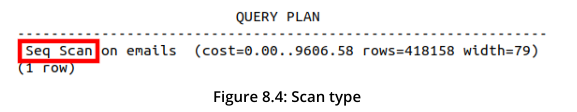

In [5]:
from IPython.display import Image
Image('images/scan_type.PNG')

O primeiro aspecto do plano fornecido é o tipo de varredura executada pela consulta. Abordaremos mais tipos de varredura mais adiante neste módulo, mas, conforme discutido com mais detalhes em breve, a Varredura Seq (consulte a Figura 8.4), ou varredura sequencial, é um tipo de consulta simples, porém robusto:

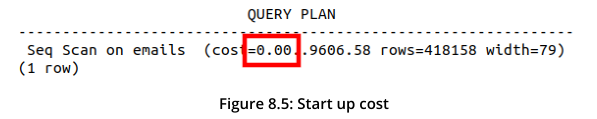

In [7]:
Image('images/start_up_cost.PNG')

A primeira medida relatada pelo planejador, conforme mostrado na Figura 8.5, é o custo inicial, que é o tempo gasto antes do início da varredura. Esse tempo pode ser necessário para primeiro classificar os dados ou concluir outros aplicativos de pré-processamento. Também é importante notar que o tempo medido é realmente relatado em unidades de custo (veja a Figura 8.5) em oposição a segundos ou milissegundos. Muitas vezes, as unidades de custo são uma indicação do número de solicitações de disco ou buscas de página feitas, em vez de ser uma medida em termos absolutos. O custo informado normalmente é mais útil como meio de comparar o desempenho de várias consultas, e não como uma medida absoluta de tempo:

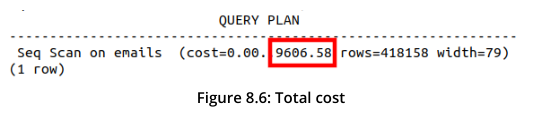

In [8]:
Image('images/total_cost.PNG')

O próximo número na sequência (veja a Figura 8.6) indica o custo total de execução da consulta se todas as linhas disponíveis forem recuperadas. Existem algumas circunstâncias em que todas as linhas disponíveis podem não ser recuperadas, mas abordaremos isso em breve:


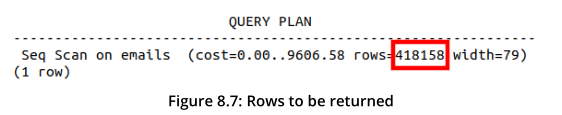

In [9]:
Image('images/rows_returned.PNG')


A próxima figura no plano (veja a Figura 8.7) indica o número total de linhas que estão disponíveis para serem retornadas – novamente, se o plano for completamente executado:

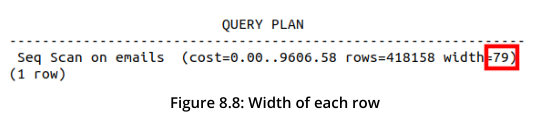

In [10]:
Image('images/width_row.PNG')

A figura final (veja a Figura 8.8), conforme sugerido por seu rótulo, indica a largura de cada linha em bytes.

> ##### Observação
> Ao executar o comando **EXPLAIN**, o **PostgreSQL** não implementa a consulta nem retorna os valores. No entanto, ele retorna uma descrição, juntamente com os custos de processamento envolvidos na execução de cada etapa do plano.

3. Consulte o plano de consulta na tabela de emails e defina o limite como 5. Insira a seguinte instrução no interpretador do PostgreSQL:

In [11]:
sql = """
		EXPLAIN SELECT *
		FROM emails
		LIMIT 5;
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Limit (cost=0.00..0.11 rows=5 width=79)
1,-> Seq Scan on emails (cost=0.00..9606.58 ...


Isso repete a afirmação anterior, onde o planejador está limitado aos cinco primeiros registros. Essa consulta produziu a seguinte saída do planejador, conforme anterior.

Referindo-se à tabela anterior, podemos ver que há duas linhas individuais no plano. Isso indica que o plano é composto por duas etapas distintas, sendo a linha inferior do plano (ou, neste caso, a primeira etapa a ser executada) uma repetição daquela mostrada na Figura 8.8. A linha superior do plano é o componente que limita o resultado a apenas **5** linhas. O processo **Limit** é um custo adicional da consulta; no entanto, é bastante insignificante em comparação com o plano de nível inferior, que recupera aproximadamente **418.158** linhas a um custo de solicitações de **9.606** páginas. O estágio **Limit** retorna apenas **5** linhas a um custo de **0,11** solicitações de página.

> ##### Observação
> O custo total estimado para uma solicitação compreende o tempo necessário para recuperar as informações do disco, bem como o número de linhas que precisam ser verificadas. Os parâmetros internos, **seq_page_cost** e **cpu_tuple_cost**, definem o custo das operações correspondentes dentro do tablespace do banco de dados. Embora não seja recomendado nesta fase, essas duas variáveis podem ser alteradas para modificar as etapas preparadas pelo planejador.

4. Agora, empregue uma consulta mais complexa, procurando por datas entre dois valores específicos na coluna **clicked_date**. Insira a seguinte instrução no interpretador *PostgreSQL*:

In [12]:
sql = """
		EXPLAIN SELECT *
		FROM emails
		WHERE clicked_date BETWEEN '2011-01-01' and '2011-02-01';
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Gather (cost=1000.00..9051.79 rows=133 width=79)
1,Workers Planned: 2
2,-> Parallel Seq Scan on emails (cost=0.00....
3,Filter: ((clicked_date >= '2011-01-01 ...


O primeiro aspecto deste plano de consulta a ser observado é que ele compreende algumas etapas diferentes. A consulta de nível inferior é semelhante à consulta anterior, pois executa uma varredura sequencial. No entanto, em vez de limitar a saída, estamos filtrando-a com base nas strings de carimbo de data/hora fornecidas. Observe que a varredura sequencial deve ser concluída em paralelo, conforme indicado pelo **Parallel Seq Scan**, e o fato de que dois trabalhadores estão planejados para serem usados. Cada varredura de sequência individual deve retornar aproximadamente 54 linhas, com um custo de 8038,49 para ser concluída. O nível superior do plano é um estado **Gather**, que é executado no início da consulta. Podemos ver aqui pela primeira vez que os custos iniciais são diferentes de zero (1.000) e totalizam **9.051,49**, incluindo as etapas de coleta e pesquisa.

Neste exercício, trabalhamos com o planejador de consultas e a saída do comando **EXPLAIN**. Essas consultas relativamente simples destacaram vários recursos do planejador de consultas SQL, bem como as informações detalhadas fornecidas por ele. Ter um bom entendimento do planejador de consultas e das informações que ele está retornando a você será muito útil em seus esforços de ciência de dados. Apenas lembre-se de que esse entendimento virá com o tempo e a prática; nunca hesite em consultar a documentação do PostgreSQL: https://www.postgresql.org/docs/current/using-explain.html.
Continuaremos a praticar a leitura de planos de consulta ao longo deste módulo à medida que examinamos os diferentes tipos de varredura e os métodos que eles usam para melhorar o desempenho.

### Atividade 10: Planejamento de consultas
Nosso objetivo nesta atividade é consultar o plano de leitura e interpretação das informações retornadas pelo planejador. Digamos que ainda estamos lidando com nosso banco de dados sqlda de registros de clientes e que nossa equipe financeira gostaria que implementássemos um sistema para gerar regularmente um relatório da atividade do cliente em uma região geográfica específica. Para garantir que nosso relatório possa ser executado em tempo hábil, precisamos de uma estimativa de quanto tempo as consultas SQL levarão. Usaremos o comando **EXPLAIN** para descobrir quanto tempo algumas das consultas de relatório levarão:
1. Abra o PostgreSQL e conecte-se ao banco de dados **sqlda**.
2. Use o comando **EXPLAIN** para retornar o plano de consulta para selecionar todos os registros disponíveis na tabela de clientes.
3. Leia a saída do plano e determine o custo total da consulta, o custo de configuração, o número de linhas a serem retornadas e a largura de cada linha. Observando a saída, quais são as unidades para cada um dos valores retornados do plano após realizar esta etapa?
4. Repita a consulta da etapa 2 desta atividade, desta vez limitando o número de registros retornados a **15**.
Observando o plano de consulta atualizado, quantas etapas estão envolvidas no plano de consulta? Qual é o custo da etapa de limitação?
5. Gere o plano de consulta, selecionando todas as linhas onde os clientes moram dentro de uma latitude de **30** e **40** graus. Qual é o custo total do plano, bem como o número de linhas retornadas pela consulta?

In [13]:
# Nr 2
sql = """
		EXPLAIN SELECT *
		FROM customers;
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Seq Scan on customers (cost=0.00..1536.00 row...


In [14]:
# Nr 3
sql = """
		EXPLAIN SELECT *
		FROM customers
		LIMIT 15;
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Limit (cost=0.00..0.46 rows=15 width=140)
1,-> Seq Scan on customers (cost=0.00..1536....


In [15]:
# Nr 3
sql = """
		EXPLAIN SELECT *
		FROM customers
		WHERE latitude > 30 AND latitude <40
      """

pd.read_sql_query(sql=sql, con=engine)

,QUERY PLAN
0,Seq Scan on customers (cost=0.00..1786.00 row...
1,Filter: ((latitude > '30'::double precision)...


Nesta atividade, praticamos a leitura dos planos retornados pelo planejador de consultas. Conforme discutido anteriormente, a leitura de planos requer prática substancial para dominá-la. Esta atividade iniciou este processo e é altamente recomendável que você use frequentemente o comando **EXPLAIN** para melhorar a leitura do seu plano.
### Verificação de índice
As varreduras de índice são um método de melhorar o desempenho de nossas consultas de banco de dados. As varreduras de índice diferem da varredura sequencial, pois uma etapa de pré-processamento é executada antes que a pesquisa de registros do banco de dados possa ocorrer. A maneira mais simples de pensar em uma varredura de índice é como o índice de um texto ou livro de referência. Ao escrever um livro de não-ficção, um editor analisa o conteúdo do livro e escreve os números das páginas correspondentes a cada tópico classificado em ordem alfabética. Assim como o editor faz o esforço inicial de criar um índice para referência do leitor, também podemos criar um índice semelhante dentro do banco de dados *PostgreSQL*. Esse índice dentro do banco de dados cria um conjunto preparado e organizado ou um subconjunto de referências aos dados sob condições especificadas. Quando uma consulta é executada e está presente um índice que contém informações relevantes para a consulta, o planejador pode optar por usar os dados que foram pré-processados e pré-organizados no índice. Sem usar um índice, o banco de dados precisa varrer repetidamente todos os registros, verificando cada registro quanto às informações de interesse.

Mesmo que todas as informações desejadas estejam no início do banco de dados, sem indexação, a pesquisa ainda varrerá todos os registros disponíveis. Claramente, isso levaria um tempo significativamente maior do que o necessário.
Existem várias estratégias de indexação diferentes que o *PostgreSQL* pode usar para criar pesquisas mais eficientes, incluindo **árvores B (B-tree), índices de hash, índices invertidos generalizados (GINs)** e **árvores de pesquisa generalizadas (GISTs)**. Cada um desses diferentes tipos de índice tem seus próprios pontos fortes e fracos e, portanto, é usado em diferentes situações. Um dos índices mais usados é o B-tree, que é a estratégia de indexação padrão usada pelo *PostgreSQL* e está disponível em quase todos os softwares de banco de dados. Primeiro, passaremos algum tempo investigando o índice da árvore B, analisando o que o torna útil, bem como algumas de suas limitações.
### O índice da árvore B
O índice B-tree é um tipo de árvore de busca binária e se caracteriza pelo fato de ser uma estrutura auto-balanceada, mantendo uma estrutura de dados própria para busca eficiente. Uma estrutura genérica de árvore B pode ser encontrada na Figura 8.12, na qual podemos ver que cada nó na árvore não tem mais do que dois elementos (dando assim equilíbrio) e que o primeiro nó tem dois filhos. Essas características são comuns entre as árvores B, onde cada nó é limitado a n componentes, forçando assim a divisão em nós filhos. Os ramos das árvores terminam nos nós folha, que, por definição, não têm filhos:

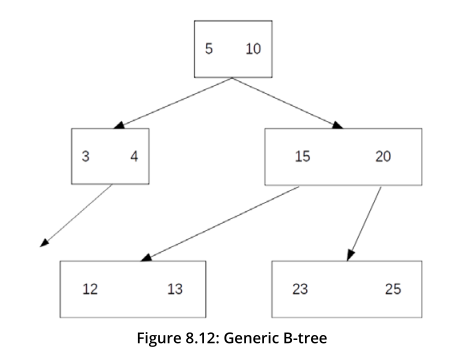

In [16]:
Image('images/b-tree.PNG')

Usando a Figura 8.12 como exemplo, digamos que estivéssemos procurando o número 13 no índice da árvore B. Começaríamos no primeiro nó e selecionaríamos se o número era menor que 5 ou maior que 10. Isso nos levaria ao galho direito da árvore, onde novamente escolheríamos entre menor que 15 e maior que 20. então selecionaria menos de 15 e chegaria à localização de 13 no índice. Podemos ver imediatamente que esta operação seria muito mais rápida do que examinar todos os valores disponíveis. Também podemos ver que, para desempenho, a árvore deve ser equilibrada para permitir um caminho fácil para a travessia. Além disso, deve haver informações suficientes para permitir a divisão. Se tivéssemos um índice de árvore com apenas alguns valores possíveis para dividir e um grande número de amostras, simplesmente dividiríamos os dados em alguns grupos.

Considerando *B-trees* (árvores B) no contexto de busca de banco de dados, podemos ver que precisamos de uma condição para dividir as informações (ou divisão), e também precisamos de informações suficientes para uma divisão significativa. Não precisamos nos preocupar com a lógica de seguir a árvore, pois ela será gerenciada pelo próprio banco de dados e pode variar de acordo com as condições de busca. Mesmo assim, é importante que entendamos os pontos fortes e fracos do método para que possamos fazer escolhas apropriadas ao criar o índice para um desempenho ideal.